## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [3]:
data = pd.read_csv("Cancer_Data.csv")
data.shape

(569, 33)

### Distribution of response
*By Juno Park*

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

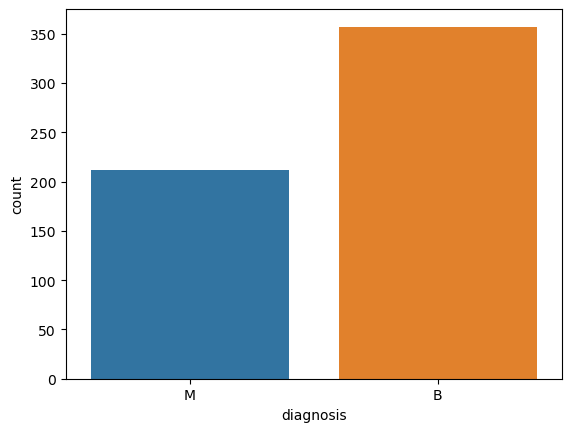

In [10]:
# Plot for distribution of response
sns.countplot(x="diagnosis", data = data)

### Data cleaning
*By Juno Park*

In [5]:
# drop any missing values
data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)
print(data.head())

rows = data[data.isnull().any(axis=1)]
cols= data.columns[data.isnull().any()]

if len(rows) == 0: 
    print('no more N/As')
    
if len(cols) == 0: 
    print('no more N/As')
    
print(data.shape)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [6]:
# Create a dummy variable for the response
data['diagnosis_dummy'] = 0
data.loc[data['diagnosis'] == 'M', 'diagnosis_dummy'] = 1

In [7]:
# Split data in 80% train 20% test
X = data.drop(columns = ['diagnosis', 'diagnosis_dummy', 'id'])
y = data['diagnosis_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

### Data preparation
*By Ryu Kimiko*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [3]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Correlation Analysis
*By Luke Lilienthal*

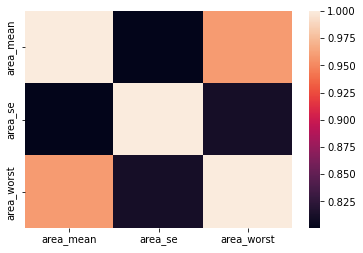

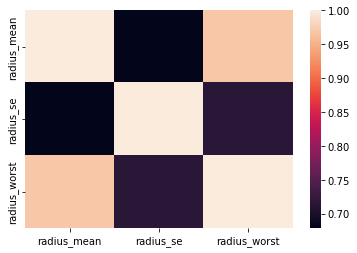

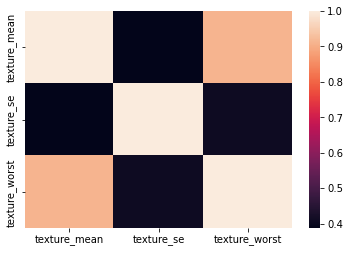

In [5]:
# Within-Category Correlation Analysis

#Take area for example
area = data[['area_mean', 'area_se', 'area_worst']]
sns.heatmap(area.corr())
plt.show()

radius = data[['radius_mean', 'radius_se', 'radius_worst']]
sns.heatmap(radius.corr())
plt.show()

texture = data[['texture_mean', 'texture_se', 'texture_worst']]
sns.heatmap(texture.corr())
plt.show()

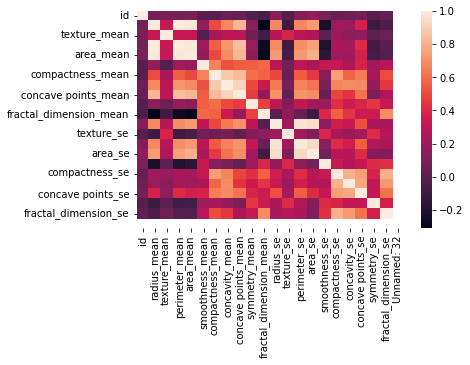

In [6]:
#General correlation analysis

# Drop worst attribute of categories- as they are highly correlated with mean
drops = data.drop(columns=['area_worst', 'radius_worst', 'texture_worst', 'perimeter_worst', 'smoothness_worst', 'compactness_worst', 
                           'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'], axis=1)
sns.heatmap(drops.corr())
# Strong correlation between size metrics (area, radius, perimeter) - size metreics se also correlated
# Many smaller but significant correlations <0.8 also present

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Decision Tree
*By Juno Park*

In [ ]:
# Naive Decision Tree Model
model = DecisionTreeClassifier(random_state=1) 

model.fit(X_train, y_train)

In [ ]:
# Maximum number of leaves
model.get_n_leaves()

In [ ]:
# Maximum depth
model.get_depth()

In [ ]:
# Grid search for optimal values
param_grid = {    
    'max_depth': range(2,5),
    'max_leaf_nodes': range(2,14),
    'max_features': range(1, 32)
}

#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5) # The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

In [ ]:
# Fields best parameters
model = DecisionTreeClassifier(random_state=1, max_depth = 2, max_leaf_nodes=3, max_features=2).fit(X_train, y_train)

# cross val predict
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 2, 
                                                        max_leaf_nodes=3, max_features=5), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])

# threshold values with precision and recall
np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.24444444 # maximize recall with decent precision

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### Bagged trees
*By Juno Park*

In [ ]:
# Bagged Trees coarse search
params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],
          'n_estimators': [150,200,250],
          'max_samples': [0.5, 0.75, 1.0],
          'max_features': [0.5, 0.75, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

In [ ]:
# Fields best parameters:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=200, 
                          random_state=1,max_features=0.5,
                        max_samples=1.0,n_jobs=-1,bootstrap=True,bootstrap_features=True).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

In [ ]:
# Finer grid search
params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],
          'n_estimators': [175, 200, 225],
          'max_samples': [0.8, 0.9, 1.0],
          'max_features': [0.4, 0.5, 0.6],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

In [ ]:
# Fields optimal parameters
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=200, 
                          random_state=1,max_features=0.5,
                        max_samples=1.0,n_jobs=-1,bootstrap=True,bootstrap_features=True).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.24

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## Random forest
*By Luke Lilienthal*

In [11]:
# RANDOM FOREST COARSE SEARCH
params = {'bootstrap': [False, True],
         'max_features': [0.3, 0.5, 0.8],
          'max_depth': [12,15,18],
          'max_leaf_nodes':[1100,1200,1300]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

rf = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring = ['accuracy', 'recall'], refit='accuracy')

rf.fit(X_train, y_train)

print('Best Parameters : ',rf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py:63: UserWarning: Failed to kill subprocesses on this platform. Please installpsutil: https://github.com/giampaolo/psutil
Details:
Traceback (most recent call last):
  File "/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 59, in _kill_process_tree_without_psutil
    _posix_recursive_kill(process.pid)
  File "/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 111, in _posix_recursive_kill
    ["pgrep", "-P", str(pid)], stderr=None, text=True
  File "/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/subprocess.py", line 356, in check_output
    **kwargs).stdout
  File "/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/subprocess.py", line 423, in run
    with Popen(*popenargs, **kwargs) as process:
TypeError: __init__()

KeyboardInterrupt: 

In [ ]:
#Fields best parameters:
model = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500, 
                               max_features=0.5, bootstrap=True, max_depth=12, max_leaf_nodes=1100).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#0.18 gives 97.6% recall and 95.6% accuracy
#0.01 gives 100% recall and 81.5% accuracy

In [ ]:
# RANDOM FOREST FINE SEARCH
params = {'bootstrap': [False, True],
         'max_features': [0.35, 0.4, 0.45],
          'max_depth': [5, 6, 7],
          'max_leaf_nodes':[500,600, 700]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

rf = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring = ['accuracy', 'recall'], refit='accuracy')

rf.fit(X_train, y_train)

print('Best Parameters : ',rf.best_params_)

In [ ]:
#Fields optimal fine parameters
model = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500, 
                               max_features=0.4, bootstrap=True, max_depth=6, max_leaf_nodes=500).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#0.18 gives 97.6% recall and 97.3% accuracy
#0.02 gives 100% recall and 83.3% accuracy

In [ ]:
thr = 0.34
y_pred_prob = model.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > thr
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
print("Recall: ", recall_score(y_test, y_pred))

## AdaBoost
*By Luke Lilienthal*

In [ ]:
# ADA BOOST COARSE GRID
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                          DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True, scoring=['accuracy', 'recall'], refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated

params = grid_result.cv_results_['params']

In [ ]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=200).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#Threshold 0.45 gives accuracy 96.5% with 100% recall - best 

In [ ]:
# ADA BOOST FINE GRID SEARCH
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = np.arange(100, 300, 10)
grid['learning_rate'] = [1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True, scoring=['accuracy', 'recall'], refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated

params = grid_result.cv_results_['params']

In [ ]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=190).fit(X_train, y_train)

prob = model.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#Threshold 0.45 gives accuracy 97.3% with 100% recall - best 

In [ ]:
thr = 0.45
y_pred_prob = model.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > thr
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
print("Recall: ", recall_score(y_test, y_pred))

# Gradient Boost
*by Alanda Zong*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time

In [2]:
cancer = pd.read_csv("Cancer_Data.csv")

In [3]:
cancer= cancer.drop(cancer.columns[cancer.columns.str.contains('unnamed',case = False)],axis = 1)
print(cancer.head())

rows = cancer[cancer.isnull().any(axis=1)]
cols= cancer.columns[cancer.isnull().any()]

if len(rows) == 0: 
    print('no more N/As')
    
if len(cols) == 0: 
    print('no more N/As')
    
print(cancer.shape)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [4]:
cancer["diagnosis"] = cancer["diagnosis"].map({"M": 1, "B": 0})

y = cancer.diagnosis # response
X = cancer.drop("diagnosis", axis = 1) #predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [5]:
start_time = time.time()
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken = ", time.time() - start_time, "seconds")

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best: 0.964706 using {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.5}
Time taken =  300.26746106147766 seconds


In [6]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Model based on the optimal parameters
model = GradientBoostingClassifier(random_state=1,max_depth=1,learning_rate=0.1,subsample=0.5,
                          n_estimators=200).fit(X_train,y_train)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(GradientBoostingClassifier(random_state=1,max_depth=1,
                                                               learning_rate=0.1,subsample=0.5,
                          n_estimators=200), X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])

In [7]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.97086646, 1.        , 0.80588235])

Accuracy:  97.36842105263158
ROC-AUC:  0.9814814814814815
Precision:  1.0
Recall:  0.9285714285714286


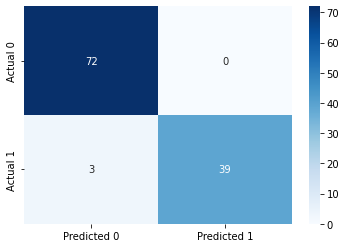

In [8]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.80588235

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# XGBoost

In [10]:
import xgboost as xgb

start_time = time.time()
param_grid = {'n_estimators':[100,400],
                'max_depth': [1, 5],
              'learning_rate': [0.01,0.1],
               'gamma': [0.1,0.25],
               'reg_lambda':[0.01,0.001],
                'scale_pos_weight':[1.25,1.5]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/alandazong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/alandazong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 400, 'reg_lambda': 0.01, 'scale_pos_weight': 1.5} 0.9758241758241759
Time taken =  0.9885791142781576  minutes


In [11]:
start_time = time.time()
param_grid = {'n_estimators':[400, 500],
                'max_depth': [1, 5],
              'learning_rate': [0.1, 0.5],
               'gamma': [0.25, 0.5],
               'reg_lambda':[0.01, 0.1],
                'scale_pos_weight':[1.5, 1.75]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/alandazong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 400, 'reg_lambda': 0.01, 'scale_pos_weight': 1.5} 0.9758241758241759
Time taken =  1.4298081994056702  minutes


In [12]:

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Model based on the optimal parameters
model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.1,max_depth=1,
                              n_estimators = 400,reg_lambda = 0.01,scale_pos_weight=1.5).fit(X_train,y_train)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.1,max_depth=1,
                              n_estimators = 400,reg_lambda = 0.01,scale_pos_weight=1.5), X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])

In [13]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.98637587, 1.        , 0.80588235])

Accuracy:  91.22807017543859
ROC-AUC:  0.9768518518518517
Precision:  1.0
Recall:  0.7619047619047619


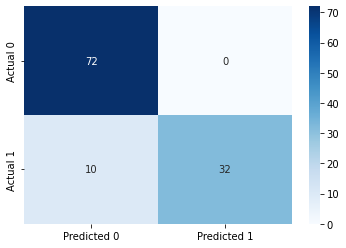

In [15]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.80588235

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## Model Ensemble 
*By Luke Lilienthal*

In [ ]:
# Best models to be ensembled
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=1, 
                         n_estimators=190).fit(X_train, y_train)

xg = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.1,max_depth=1,
                              n_estimators = 400,reg_lambda = 0.01,scale_pos_weight=1.5).fit(X_train,y_train)

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=200, 
                          random_state=1,max_features=0.5,
                        max_samples=1.0,n_jobs=-1,bootstrap=True,bootstrap_features=True).fit(X_train, y_train)

### Voting ensemble

In [ ]:
# Train VotingClassifier model
en=VotingClassifier(estimators = [('xgb',xg),('ada',ada),('bag',bag)], voting='soft')
en.fit(X_train,y_train)

prob = en.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

#Select an optimal training threshold
for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

In [ ]:
#Giving test results
thr = 0.31
y_pred_prob = en.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > thr
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
print("Recall: ", recall_score(y_test, y_pred))

Notably, this performs worse than the individual AdaBoost model.

### Stacking ensembles

In [ ]:
# Training StackingClassifier model
en=StackingClassifier(estimators = [('xgb',xg),('ada',ada),('bag',bag)],
                     final_estimator=LogisticRegression(random_state=1,max_iter=10000))
en.fit(X_train,y_train)

prob = en.predict_proba(X_train)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

#Select an optimal training threshold
for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_train, pred)
  recall = recall_score(y_train, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

In [ ]:
thr = 0.13
y_pred_prob = en.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > thr
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
print("Recall: ", recall_score(y_test, y_pred))

Again, results are worse than the AdaBoost model. It seems that we have one dominant model in our solution set that makes ensembling not particularly effective.

### Ensemble of ensembled models

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.